# Creating an unbiased train/valid split

1. How biased is a simple <2016/2016 split? Answer: There doesn't seem to be a large bias. This means I can simply use this split to test for overfitting.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.train_nn import *
import matplotlib.pyplot as plt

/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [3]:
limit_mem()

In [4]:
datadir = '/data/weather-benchmark/5.625deg/'

In [5]:
z = xr.open_mfdataset(f'{datadir}geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{datadir}temperature_850/*.nc', combine='by_coords')
ds = xr.merge([z, t])

## How biased is a simple <2016/2016 split?

In [6]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [7]:
dic = {'z': None, 't': None}

In [8]:
batch_size = 32
lead_time = 3*24

In [9]:
dummy = DataGenerator(ds_train.isel(time=slice(0, None, 5*12)), dic, lead_time, batch_size=batch_size, shuffle=False)
dg_train = DataGenerator(ds_train, dic, lead_time, batch_size=batch_size, mean=dummy.mean,
                         std=dummy.std, shuffle=False)
dg_valid = DataGenerator(ds_valid, dic, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False)
dg_test =  DataGenerator(ds_test, dic, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False)
dg_fake =  DataGenerator(ds_test.sel(time='2018'), dic, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std)

Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [10]:
model = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], input_shape=(32, 64, 2), activation='elu')
model.compile(keras.optimizers.Adam(), 'mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model.fit_generator(dg_fake, epochs=1)

272/272 [==============================] - 13s 49ms/step - loss: 0.7801


In [12]:
model.evaluate_generator(dg_train, verbose=1)

10134/10134 [==============================] - 107s 11ms/step - loss: 0.5371


0.5371004267600671

In [13]:
model.evaluate_generator(dg_valid, verbose=1)

273/273 [==============================] - 3s 11ms/step - loss: 0.5340


0.5339983230108744

In [14]:
model.evaluate_generator(dg_test, verbose=1)

546/546 [==============================] - 6s 10ms/step - loss: 0.5252


0.5252001736408625

In [15]:
# Create predictions from an untrained model
preds_train = create_predictions(model, dg_train)

In [16]:
preds_valid = create_predictions(model, dg_valid)
preds_test = create_predictions(model, dg_test)

In [17]:
rmse_train = compute_weighted_rmse(preds_train.isel(time=slice(0, None, 36)), ds).load(); rmse_train

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 850
Data variables:
    z_rmse   float64 746.0
    t_rmse   float64 3.429

In [18]:
rmse_valid = compute_weighted_rmse(preds_valid, ds).load(); rmse_valid

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 850
Data variables:
    z_rmse   float64 746.4
    t_rmse   float64 3.422

In [19]:
rmse_test = compute_weighted_rmse(preds_test, ds).load(); rmse_test

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 850
Data variables:
    z_rmse   float64 739.8
    t_rmse   float64 3.414

In [30]:
len(dg_train), len(dg_valid)

(10134, 273)

In [37]:
mses_train = []
for i in range(len(dg_valid))[::-1]:
    x, y = dg_train[-i]
    p = model.predict_on_batch(x)
    mses_train.append(((y - p)**2).mean())

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """


In [38]:
mses_valid = []
for i in range(len(dg_valid)):
    x, y = dg_valid[i]
    p = model.predict_on_batch(x)
    mses_valid.append(((y - p)**2).mean())

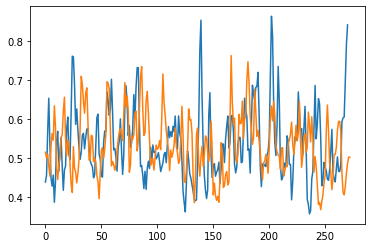

In [39]:
plt.plot(mses_train)
plt.plot(mses_valid)